In [1]:
from __future__ import print_function
from fenics import *
import mshr

In [2]:
# Variables
L = 1
H = 1
E = Constant(0.550)
nu = Constant(0.2)

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)

In [33]:
# Create mesh and define function space
cx = [.25,.50,.75]
cy = [.25,.50,.75]
R = [.1,.1,.1]
Circles = [mshr.Circle(Point(cx[0],cy[0]), R[0]),
           mshr.Circle(Point(cx[1],cy[1]), R[1]),
           mshr.Circle(Point(cx[2],cy[2]), R[2])]
domain = mshr.Rectangle(Point(0.,0.), Point(L, H)) - Circles[0] - Circles[1] - Circles[2]
mesh = mshr.generate_mesh(domain, 200)

V = VectorFunctionSpace(mesh, 'P', 1)

In [34]:
# Constitutive relation
def eps(v):
    return sym(grad(v))

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

In [35]:
# Define variational problem
f = Constant((0.0, 0.0))
u = TrialFunction(V)
v = TestFunction(V)

a = inner(sigma(u),eps(v))*dx
l = inner(f,v)*dx

In [36]:
# Define boundary condition
tol = 1E-14
def BC_up(x, on_boundary):
    return on_boundary and H-x[1] < tol
def BC_down(x, on_boundary):
    return on_boundary and x[1] < tol

bcU = DirichletBC(V, Constant((0.,0.01)), BC_up)
bcD = DirichletBC(V, Constant((0.,0.)), BC_down)
bcs = [bcU,bcD]

In [37]:
# Solve
u = Function(V, name="Displacement")
solve(a == l, u, bcs)

Solving linear variational problem.


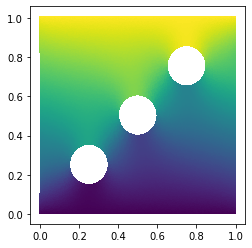

In [38]:
plot(u, mode='displacement')

Object cannot be plotted directly, projecting to piecewise linears.


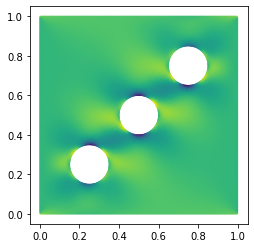

In [39]:
plot(sigma(u)[0,0], mode='color')

Object cannot be plotted directly, projecting to piecewise linears.


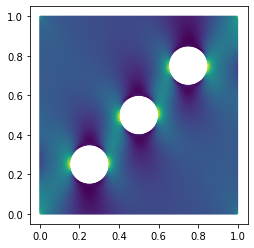

In [40]:
plot(eps(u)[1,1], mode='color')

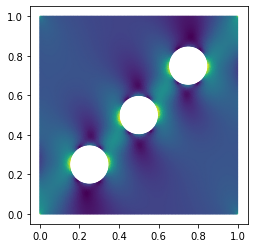

In [41]:
def mis_eps(u):
    eps_dev = eps(u) - Identity(2)*tr(eps(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sigma(u):
    sigma_dev = sigma(u) - Identity(2)*tr(sigma(u))
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

Vs = FunctionSpace(mesh, 'P', 1) # scalar
eps_Mis = project(mis_eps(u),Vs)
sigma_Mis = project(mis_sigma(u),Vs)
plot(eps_Mis, mode='color')

In [42]:
# Save solution to file in VTK format
Vt = TensorFunctionSpace(mesh, 'P', 1)
eps_u = eps(u)
sigma_u = sigma(u)
eps_u = project(eps_u,Vt)
sigma_u = project(sigma_u,Vt)
File('test_sample_design/displacement.pvd') << u
File('test_sample_design/stress_Mis.pvd') << sigma_Mis
File('test_sample_design/strain_Mis.pvd') << eps_Mis
File('test_sample_design/strain.pvd') << eps_u
File('test_sample_design/stess.pvd') << sigma_u